# 911 Exploratory Analysis Project

For this project we'll analyze the 911 call dataset from [Kaggle](https://www.kaggle.com/mchirico/montcoalert). The data contains the following fields:

* lat : String variable, Latitude
* lng: String variable, Longitude
* desc: String variable, Description of the Emergency Call
* zip: String variable, Zipcode
* title: String variable, Title
* timeStamp: String variable, YYYY-MM-DD HH:MM:SS
* twp: String variable, Township
* addr: String variable, Address
* e: String variable, Dummy variable (always 1)

Let's start with some data analysis and visualisation imports.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt




#import warnings
#warnings.filterwarnings("ignore")

In [2]:
import chart_studio.plotly as py
import plotly.graph_objs as go
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import datetime
# Get the best fitting line

# Need to import for legend
import matplotlib.lines as mlines

# For best fit line
from sklearn import linear_model

#for clustering
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline

font={
    'size':20
}
sns.set(style="white", color_codes=True)

plt.rcParams['figure.figsize'] = (6, 4)

file_location = 'data/911.csv'

C:\Users\Diogo\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.



In [4]:
#Reading the data
df = pd.read_csv(file_location)

In [5]:
#Checking the head of the dataframe
df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 17:40:00,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 17:40:01,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 17:40:01,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


## Basic Analysis

Let's check out the top 5 zipcodes for calls.

In [6]:
df['zip'].value_counts().head(5)

19401.0    6979
19464.0    6643
19403.0    4854
19446.0    4748
19406.0    3174
Name: zip, dtype: int64

The top townships for the calls were as follows:

In [7]:
df['twp'].value_counts().head(5)

LOWER MERION    8443
ABINGTON        5977
NORRISTOWN      5890
UPPER MERION    5227
CHELTENHAM      4575
Name: twp, dtype: int64

For 90k + entries, how many unique call titles did we have? 

In [8]:
df['title'].nunique()

110

In [9]:
df['Reason'] = df['title'].apply(lambda x: x.split(':')[0])
df_1 = df
df_1['lat'] = df_1['lat'].round(2)
df_1['lng'] = df_1['lng'].round(2)
statedist = df_1.pivot_table(index=['lat','lng'],columns='Reason',values='e',aggfunc=np.sum)
statedist.reset_index(inplace=True)
statedist.fillna(value=0,inplace=True)
statedist['Distribution'] = statedist['EMS'].name + statedist['EMS'].astype(str)+\
                        '<br>'+statedist['Fire'].name + statedist['Fire'].astype(str)+\
                        '<br>'+statedist['Traffic'].name + statedist['Traffic'].astype(str)
statedist.columns.rename('',inplace=True) #rename the column 

print('df_1:',len(df_1),'','statedist:',len(statedist))
statedist.head()

df_1: 99492  statedist: 1563


,lat,lng,EMS,Fire,Traffic,Distribution
0,30.33,-95.60,1.0,0.0,0.0,EMS1.0<br>Fire0.0<br>Traffic0.0
1,32.39,-86.28,0.0,0.0,1.0,EMS0.0<br>Fire0.0<br>Traffic1.0
2,39.75,-84.40,0.0,2.0,0.0,EMS0.0<br>Fire2.0<br>Traffic0.0
3,39.96,-75.27,1.0,0.0,2.0,EMS1.0<br>Fire0.0<br>Traffic2.0
4,39.96,-75.25,2.0,1.0,0.0,EMS2.0<br>Fire1.0<br>Traffic0.0


In [10]:
del df_1

In [11]:
data = [ dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = statedist['lng'],
        lat = statedist['lat'],
        text = statedist['Distribution'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            symbol = 'circle',

            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            )

        ))]

layout = dict(
        title = 'Emergence Call Geographical Distribution',
        #colorbar = True,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            showlakes = True,

            lakecolor = "rgb(255, 255, 255)",
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
iplot(fig)

## Data Wrangling for Feature Creation

We can extract some generalised features from the columns in our dataset for further analysis. 

In the _title_ column, there's a kind of 'subcategory' or 'reason for call' alloted to each entry (denoted by the text before the colon). 

The timestamp column can be further segregated into Year, Month and Day of Week too. 


In [12]:
df.tail()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e,Reason
99487,40.13,-75.33,MARKLEY ST & W LOGAN ST; NORRISTOWN; 2016-08-2...,19401.0,Traffic: VEHICLE ACCIDENT -,2016-08-24 11:06:00,NORRISTOWN,MARKLEY ST & W LOGAN ST,1,Traffic
99488,40.01,-75.29,LANCASTER AVE & RITTENHOUSE PL; LOWER MERION; ...,19003.0,Traffic: VEHICLE ACCIDENT -,2016-08-24 11:07:02,LOWER MERION,LANCASTER AVE & RITTENHOUSE PL,1,Traffic
99489,40.12,-75.33,CHESTNUT ST & WALNUT ST; NORRISTOWN; Station ...,19401.0,EMS: FALL VICTIM,2016-08-24 11:12:00,NORRISTOWN,CHESTNUT ST & WALNUT ST,1,EMS
99490,40.19,-75.19,WELSH RD & WEBSTER LN; HORSHAM; Station 352; ...,19002.0,EMS: NAUSEA/VOMITING,2016-08-24 11:17:01,HORSHAM,WELSH RD & WEBSTER LN,1,EMS
99491,40.21,-75.32,MORRIS RD & S BROAD ST; UPPER GWYNEDD; 2016-08...,19446.0,Traffic: VEHICLE ACCIDENT -,2016-08-24 11:17:02,UPPER GWYNEDD,MORRIS RD & S BROAD ST,1,Traffic


Now, let's find out the most common reason for 911 calls, according to our dataset.

In [13]:
df['Reason'].value_counts()

EMS        48877
Traffic    35695
Fire       14920
Name: Reason, dtype: int64

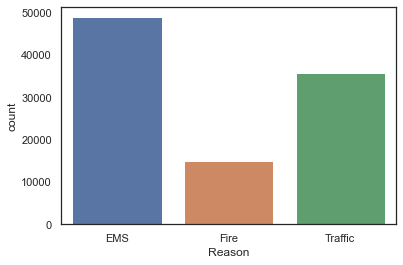

In [14]:
sns.countplot(df['Reason'])

Let's deal with the time information we have. Checking the datatype of the timestamp column.

In [15]:
type(df['timeStamp'][0])

str

As the timestamps are still string types, it'll make our life easier if we convert it to a python DateTime object, so we can extract the year, month, and day information more intuitively. 

In [16]:
df['timeStamp'] = pd.to_datetime(df['timeStamp'])

For a single DateTime object, we can extract information as follows.

In [17]:
time = df['timeStamp'].iloc[0]

print('Hour:',time.hour)
print('Month:',time.month)
print('Day of Week:',time.dayofweek)

Hour: 17
Month: 12
Day of Week: 3


Now let's create new features for the above pieces of information.

In [18]:
df['Hour'] = df['timeStamp'].apply(lambda x: x.hour)
df['Month'] = df['timeStamp'].apply(lambda x: x.month)
df['Day of Week'] = df['timeStamp'].apply(lambda x: x.dayofweek)

In [19]:
df.head(3)

,lat,lng,desc,zip,title,timeStamp,twp,addr,e,Reason,Hour,Month,Day of Week
0,40.30,-75.58,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,1,EMS,17,12,3
1,40.26,-75.26,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1,EMS,17,12,3
2,40.12,-75.35,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 17:40:00,NORRISTOWN,HAWS AVE,1,Fire,17,12,3


The Day of the Week is an integer and it might not be instantly clear which number refers to which Day. We can map that information to a Mon-Sun string.

In [20]:
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}

In [21]:
df['Day of Week'] = df['Day of Week'].map(dmap)

df.tail(3)

,lat,lng,desc,zip,title,timeStamp,twp,addr,e,Reason,Hour,Month,Day of Week
99489,40.12,-75.33,CHESTNUT ST & WALNUT ST; NORRISTOWN; Station ...,19401.0,EMS: FALL VICTIM,2016-08-24 11:12:00,NORRISTOWN,CHESTNUT ST & WALNUT ST,1,EMS,11,8,Wed
99490,40.19,-75.19,WELSH RD & WEBSTER LN; HORSHAM; Station 352; ...,19002.0,EMS: NAUSEA/VOMITING,2016-08-24 11:17:01,HORSHAM,WELSH RD & WEBSTER LN,1,EMS,11,8,Wed
99491,40.21,-75.32,MORRIS RD & S BROAD ST; UPPER GWYNEDD; 2016-08...,19446.0,Traffic: VEHICLE ACCIDENT -,2016-08-24 11:17:02,UPPER GWYNEDD,MORRIS RD & S BROAD ST,1,Traffic,11,8,Wed


Let's combine the newly created features, to check out the most common call reasons based on the day of the week.

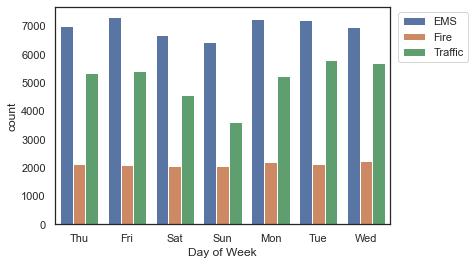

In [22]:
sns.countplot(df['Day of Week'],hue=df['Reason'])

plt.legend(bbox_to_anchor=(1.25,1))

It makes sense for the number of traffic related 911 calls to be the lowest during the weekends, what's also iteresting is that Emergency Service related calls are also low during the weekend.

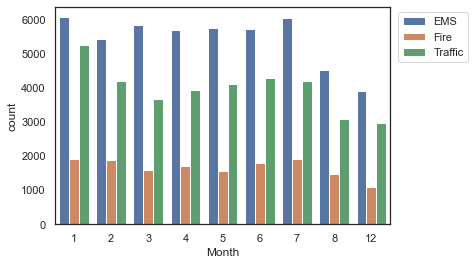

In [23]:
sns.countplot(df['Month'],hue=df['Reason'])

plt.legend(bbox_to_anchor=(1.25,1))

Now, let's check out the relationship between the number of calls and the month.

In [24]:
byMonth = df.groupby('Month').count()

Text(0, 0.5, 'Number of Calls')

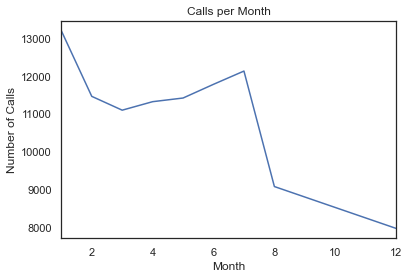

In [25]:
byMonth['e'].plot.line(y='e')
plt.title('Calls per Month')
plt.ylabel('Number of Calls')

Using seaborn, let's fit the number of calls to a month and see if there's any concrete correlation between the two.

In [26]:
byMonth.reset_index(inplace=True)

Text(-6.289999999999999, 0.5, 'Number of Calls')

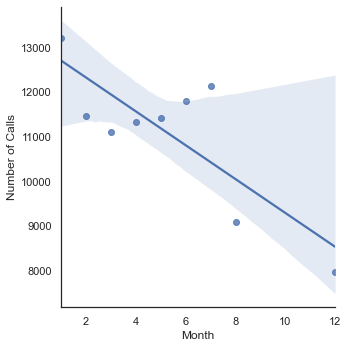

In [27]:
sns.lmplot(x='Month',y='e',data=byMonth)
plt.ylabel('Number of Calls')

So, it does seem that there are fewer emergency calls during the holiday seasons.

Let's extract the date from the timestamp, and see behavior in a little more detail.

In [28]:
df['Date']=df['timeStamp'].apply(lambda x: x.date())

In [29]:
df.head(2)

,lat,lng,desc,zip,title,timeStamp,twp,addr,e,Reason,Hour,Month,Day of Week,Date
0,40.30,-75.58,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,1,EMS,17,12,Thu,2015-12-10
1,40.26,-75.26,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1,EMS,17,12,Thu,2015-12-10


Grouping and plotting the data: 

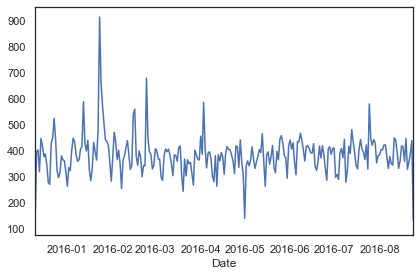

In [30]:
df.groupby('Date').count()['e'].plot.line(y='e')

plt.legend().remove()
plt.tight_layout()

We can also check out the same plot for each reason separately.

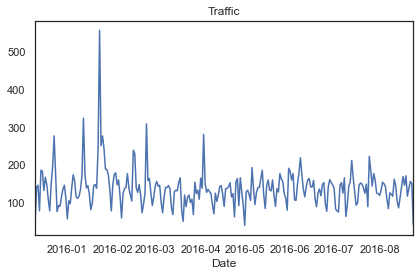

In [31]:
df[df['Reason']=='Traffic'].groupby('Date').count().plot.line(y='e')
plt.title('Traffic')
plt.legend().remove()
plt.tight_layout()

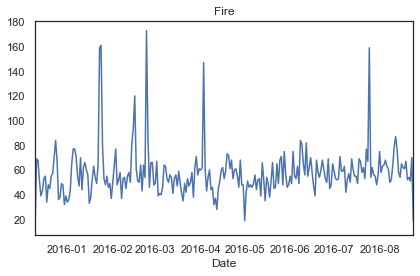

In [32]:
df[df['Reason']=='Fire'].groupby('Date').count().plot.line(y='e')
plt.title('Fire')
plt.legend().remove()
plt.tight_layout()

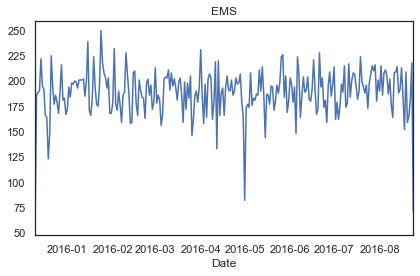

In [33]:
df[df['Reason']=='EMS'].groupby('Date').count().plot.line(y='e')
plt.title('EMS')
plt.legend().remove()
plt.tight_layout()

Let's create a heatmap for the counts of calls on each hour, during a given day of the week.

In [34]:
day_hour = df.pivot_table(values='lat',index='Day of Week',columns='Hour',aggfunc='count')

day_hour

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Day of Week,,,,,,,,,,,,,,,,,,,,,
Fri,275,235,191,175,201,194,372,598,742,752,...,932,980,1039,980,820,696,667,559,514,474
Mon,282,221,201,194,204,267,397,653,819,786,...,869,913,989,997,885,746,613,497,472,325
Sat,375,301,263,260,224,231,257,391,459,640,...,789,796,848,757,778,696,628,572,506,467
Sun,383,306,286,268,242,240,300,402,483,620,...,684,691,663,714,670,655,537,461,415,330
Thu,278,202,233,159,182,203,362,570,777,828,...,876,969,935,1013,810,698,617,553,424,354
Tue,269,240,186,170,209,239,415,655,889,880,...,943,938,1026,1019,905,731,647,571,462,274
Wed,250,216,189,209,156,255,410,701,875,808,...,904,867,990,1037,894,686,668,575,490,335


** Now create a HeatMap using this new DataFrame. **

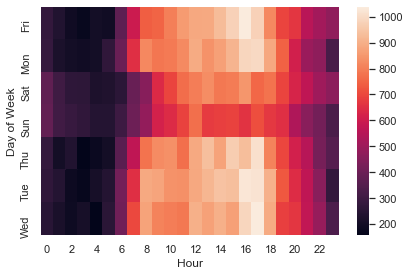

In [35]:
sns.heatmap(day_hour)

plt.tight_layout()

We see that most calls take place around the end of office hours on weekdays. We can create a clustermap to pair up similar Hours and Days.

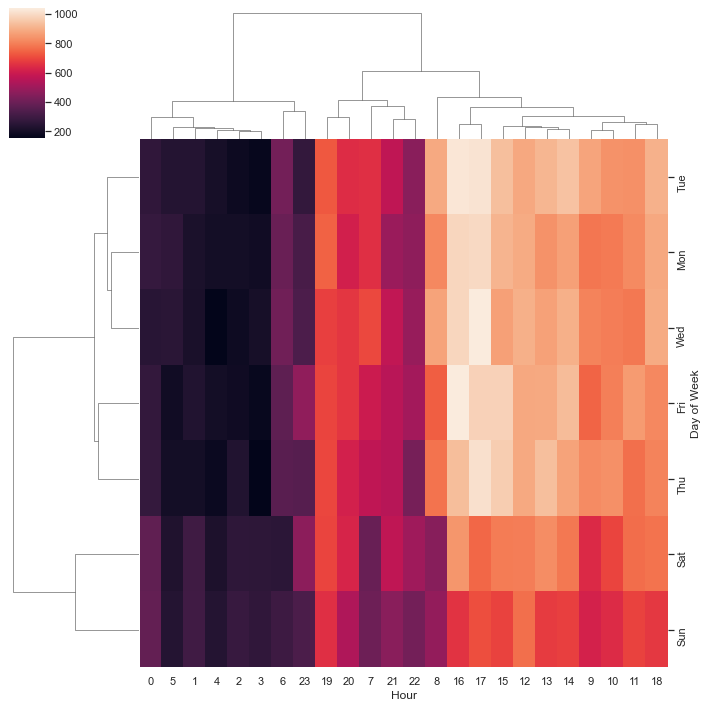

In [36]:
sns.clustermap(day_hour)

In [37]:
dateparse = lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')

# Read data 
d=pd.read_csv(file_location,
    header=0,names=['lat', 'lng','desc','zip','title','timeStamp','twp','addr','e'],
    dtype={'lat':str,'lng':str,'desc':str,'zip':str,
                  'title':str,'timeStamp':str,'twp':str,'addr':str,'e':int}, 
     parse_dates=['timeStamp'],date_parser=dateparse)


# Set timeStamp
d.timeStamp = pd.DatetimeIndex(d.timeStamp)
d=d[(d.timeStamp >= "2016-01-01 00:00:00")]

In [38]:
# Title is the category of the call
d["title"].value_counts()

Traffic: VEHICLE ACCIDENT -             20889
Traffic: DISABLED VEHICLE -              7187
Fire: FIRE ALARM                         5061
EMS: RESPIRATORY EMERGENCY               4683
EMS: CARDIAC EMERGENCY                   4589
EMS: FALL VICTIM                         4473
EMS: VEHICLE ACCIDENT                    3574
Traffic: ROAD OBSTRUCTION -              2949
EMS: SUBJECT IN PAIN                     2504
EMS: HEAD INJURY                         2440
EMS: UNKNOWN MEDICAL EMERGENCY           1730
EMS: SYNCOPAL EPISODE                    1576
EMS: SEIZURES                            1499
Fire: VEHICLE ACCIDENT                   1486
Fire: FIRE INVESTIGATION                 1363
EMS: GENERAL WEAKNESS                    1338
EMS: ABDOMINAL PAINS                     1308
EMS: ALTERED MENTAL STATUS               1287
EMS: MEDICAL ALERT ALARM                 1255
EMS: HEMORRHAGING                        1164
EMS: CVA/STROKE                          1113
EMS: OVERDOSE                     

In [39]:
# There are 3 groups -- EMS, Fire, Traffic
# We'll call these type.  This type is split on ':'
d['type'] = d["title"].apply(lambda x: x.split(':')[0])

In [40]:
# Let's create a pivot table with just EMS
# It will be stored in a variable 'pp'
g=d[d['type'] == 'EMS' ]
p=pd.pivot_table(g, values='e', index=['timeStamp'], columns=['title'], aggfunc=np.sum)

# Resampling every week 'W'.  This is very powerful
pp=p.resample('W', how=[np.sum]).reset_index()
pp.head()

C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning:

how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)



,timeStamp,EMS: ABDOMINAL PAINS,EMS: ACTIVE SHOOTER,EMS: ALLERGIC REACTION,EMS: ALTERED MENTAL STATUS,EMS: AMPUTATION,EMS: ANIMAL BITE,EMS: APPLIANCE FIRE,EMS: ASSAULT VICTIM,EMS: BACK PAINS/INJURY,...,EMS: TRAIN CRASH,EMS: TRANSFERRED CALL,EMS: UNCONSCIOUS SUBJECT,EMS: UNKNOWN MEDICAL EMERGENCY,EMS: UNKNOWN TYPE FIRE,EMS: UNRESPONSIVE SUBJECT,EMS: VEHICLE ACCIDENT,EMS: VEHICLE FIRE,EMS: WARRANT SERVICE,EMS: WOODS/FIELD FIRE
,,sum,sum,sum,sum,sum,sum,sum,sum,sum,...,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
0,2016-01-03,19.0,0.0,5.0,13.0,0.0,0.0,0.0,11.0,9.0,...,0.0,0.0,14.0,11.0,1.0,17.0,34.0,1.0,0.0,0.0
1,2016-01-10,43.0,0.0,8.0,46.0,0.0,2.0,1.0,19.0,23.0,...,0.0,0.0,23.0,57.0,0.0,38.0,102.0,1.0,0.0,0.0
2,2016-01-17,42.0,0.0,8.0,33.0,1.0,1.0,0.0,10.0,28.0,...,0.0,0.0,24.0,49.0,0.0,33.0,128.0,1.0,0.0,0.0
3,2016-01-24,45.0,0.0,11.0,37.0,3.0,5.0,0.0,4.0,17.0,...,0.0,0.0,24.0,51.0,0.0,44.0,85.0,0.0,0.0,0.0
4,2016-01-31,37.0,0.0,13.0,31.0,0.0,0.0,0.0,16.0,31.0,...,0.0,1.0,33.0,47.0,0.0,34.0,74.0,0.0,0.0,0.0


In [41]:
# That "sum" column is a pain...remove it

# Let's flatten the columns 
pp.columns = pp.columns.get_level_values(0)

pp.head()

,timeStamp,EMS: ABDOMINAL PAINS,EMS: ACTIVE SHOOTER,EMS: ALLERGIC REACTION,EMS: ALTERED MENTAL STATUS,EMS: AMPUTATION,EMS: ANIMAL BITE,EMS: APPLIANCE FIRE,EMS: ASSAULT VICTIM,EMS: BACK PAINS/INJURY,...,EMS: TRAIN CRASH,EMS: TRANSFERRED CALL,EMS: UNCONSCIOUS SUBJECT,EMS: UNKNOWN MEDICAL EMERGENCY,EMS: UNKNOWN TYPE FIRE,EMS: UNRESPONSIVE SUBJECT,EMS: VEHICLE ACCIDENT,EMS: VEHICLE FIRE,EMS: WARRANT SERVICE,EMS: WOODS/FIELD FIRE
0,2016-01-03,19.0,0.0,5.0,13.0,0.0,0.0,0.0,11.0,9.0,...,0.0,0.0,14.0,11.0,1.0,17.0,34.0,1.0,0.0,0.0
1,2016-01-10,43.0,0.0,8.0,46.0,0.0,2.0,1.0,19.0,23.0,...,0.0,0.0,23.0,57.0,0.0,38.0,102.0,1.0,0.0,0.0
2,2016-01-17,42.0,0.0,8.0,33.0,1.0,1.0,0.0,10.0,28.0,...,0.0,0.0,24.0,49.0,0.0,33.0,128.0,1.0,0.0,0.0
3,2016-01-24,45.0,0.0,11.0,37.0,3.0,5.0,0.0,4.0,17.0,...,0.0,0.0,24.0,51.0,0.0,44.0,85.0,0.0,0.0,0.0
4,2016-01-31,37.0,0.0,13.0,31.0,0.0,0.0,0.0,16.0,31.0,...,0.0,1.0,33.0,47.0,0.0,34.0,74.0,0.0,0.0,0.0


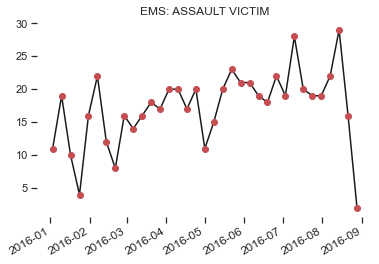

In [42]:
# Red dot with Line
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)  



ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
plt.xticks(fontsize=12) 



ax.plot_date(pp['timeStamp'], pp['EMS: ASSAULT VICTIM'],'k')
ax.plot_date(pp['timeStamp'], pp['EMS: ASSAULT VICTIM'],'ro')


ax.set_title("EMS: ASSAULT VICTIM")
fig.autofmt_xdate()
plt.show()

# Note, you'll get a drop at the ends...not a complete week

In [43]:
# Remove the first and last row
pp = pp[pp['timeStamp'] < pp['timeStamp'].max()]
pp = pp[pp['timeStamp'] > pp['timeStamp'].min()]

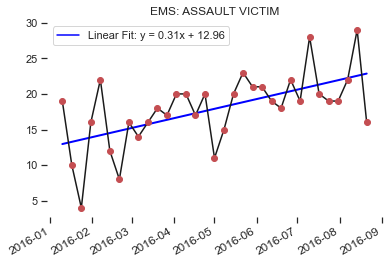

In [44]:
# Red dot with Line
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)  



ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
plt.xticks(fontsize=12) 



# Build Linear Fit
Y = pp['EMS: ASSAULT VICTIM'].values.reshape(-1,1)
X=np.arange(Y.shape[0]).reshape(-1,1)
model = linear_model.LinearRegression()
model.fit(X,Y)
m = model.coef_[0][0]
c = model.intercept_[0]
ax.plot(pp['timeStamp'],model.predict(X), color='blue',
         linewidth=2)
blue_line = mlines.Line2D([], [], color='blue', label='Linear Fit: y = %2.2fx + %2.2f' % (m,c))
ax.legend(handles=[blue_line], loc='best')


ax.plot_date(pp['timeStamp'], pp['EMS: ASSAULT VICTIM'],'k')
ax.plot_date(pp['timeStamp'], pp['EMS: ASSAULT VICTIM'],'ro')


ax.set_title("EMS: ASSAULT VICTIM")
fig.autofmt_xdate()
plt.show()

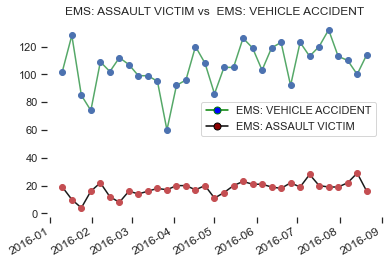

In [45]:
fig, ax = plt.subplots()

ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)  


ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left() 
plt.xticks(fontsize=12) 


ax.plot_date(pp['timeStamp'], pp['EMS: ASSAULT VICTIM'],'k')
ax.plot_date(pp['timeStamp'], pp['EMS: ASSAULT VICTIM'],'ro')


ax.plot_date(pp['timeStamp'], pp['EMS: VEHICLE ACCIDENT'],'g')
ax.plot_date(pp['timeStamp'], pp['EMS: VEHICLE ACCIDENT'],'bo')


ax.set_title("EMS: ASSAULT VICTIM vs  EMS: VEHICLE ACCIDENT")


# Legend Stuff
green_line = mlines.Line2D([], [], color='green', marker='o',markerfacecolor='blue',
                          markersize=7, label='EMS: VEHICLE ACCIDENT')
black_line = mlines.Line2D([], [], color='black', marker='o',markerfacecolor='darkred',
                          markersize=7, label='EMS: ASSAULT VICTIM')

ax.legend(handles=[green_line,black_line], loc='best')


fig.autofmt_xdate()
plt.show()

# Note scale hides the assault increase 

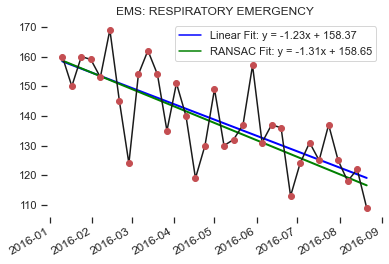

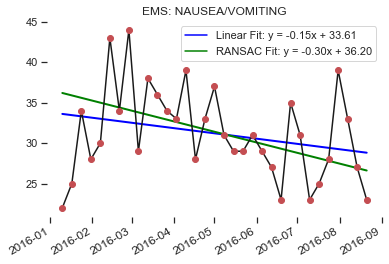

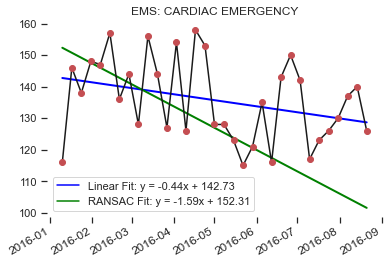

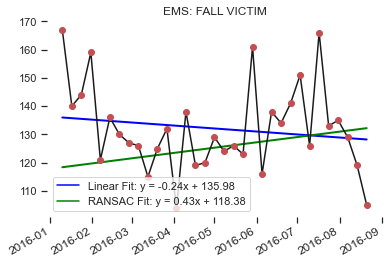

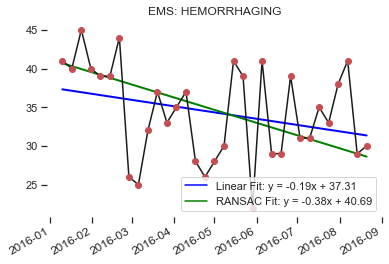

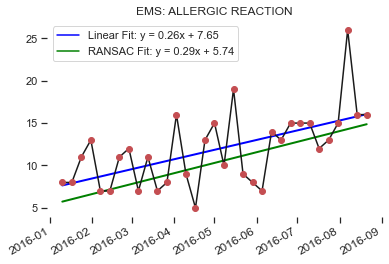

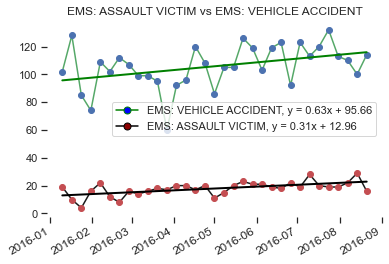

In [46]:
from sklearn import linear_model
import matplotlib.lines as mlines

def plotWLine(category='EMS: ASSAULT VICTIM'):

    
    fig, ax = plt.subplots()

    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)  



    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left() 
    plt.xticks(fontsize=12) 



    # Build Linear Fit
    Y = pp[category].values.reshape(-1,1)
    X=np.arange(Y.shape[0]).reshape(-1,1)
    model = linear_model.LinearRegression()
    model.fit(X,Y)
    m = model.coef_[0][0]
    c = model.intercept_[0]
    ax.plot(pp['timeStamp'],model.predict(X), color='blue',
             linewidth=2)
    blue_line = mlines.Line2D([], [], color='blue', label='Linear Fit: y = %2.2fx + %2.2f' % (m,c))
    

    
    # Robustly fit linear model with RANSAC algorithm
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(),random_state=23)
    model_ransac.fit(X, Y)
    mr = model_ransac.estimator_.coef_[0][0]
    cr = model_ransac.estimator_.intercept_[0]
    ax.plot(pp['timeStamp'],model_ransac.predict(X), color='green',
             linewidth=2)
    green_line = mlines.Line2D([], [], color='green', label='RANSAC Fit: y = %2.2fx + %2.2f' % (mr,cr))


    
    ax.legend(handles=[blue_line,green_line], loc='best')
    

    ax.plot_date(pp['timeStamp'], pp[category],'k')
    ax.plot_date(pp['timeStamp'], pp[category],'ro')


    ax.set_title(category)
    fig.autofmt_xdate()
    plt.show()
    print('\n')


    
def plot2WLine(cat1='EMS: ASSAULT VICTIM',cat2='EMS: VEHICLE ACCIDENT'):
    
    fig, ax = plt.subplots()

    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)  



    ax.get_xaxis().tick_bottom()    
    ax.get_yaxis().tick_left() 
    plt.xticks(fontsize=12) 

    

    ax.plot_date(pp['timeStamp'], pp[cat1],'k')
    ax.plot_date(pp['timeStamp'], pp[cat1],'ro')


    ax.plot_date(pp['timeStamp'], pp[cat2],'g')
    ax.plot_date(pp['timeStamp'], pp[cat2],'bo')


    
    
# Build Linear Fit
    
    # cat 1
    Y = pp[cat1].values.reshape(-1,1)
    X=np.arange(Y.shape[0]).reshape(-1,1)
    model = linear_model.LinearRegression()
    model.fit(X,Y)
    m = model.coef_[0][0]
    c = model.intercept_[0]
    ax.plot(pp['timeStamp'],model.predict(X), color='black',
             linewidth=2)
    
    black_line = mlines.Line2D([], [], color='black', marker='o',markerfacecolor='darkred',
                               markersize=7,
                               label='%s, y = %2.2fx + %2.2f' % (cat1,m,c))
  
    # cat 2
    Y = pp[cat2].values.reshape(-1,1)
    X=np.arange(Y.shape[0]).reshape(-1,1)
    model = linear_model.LinearRegression()
    model.fit(X,Y)
    m = model.coef_[0][0]
    c = model.intercept_[0]
    ax.plot(pp['timeStamp'],model.predict(X), color='green',
             linewidth=2)
    
    green_line = mlines.Line2D([], [], color='green',marker='o',markerfacecolor='blue',
                          markersize=7, label='%s, y = %2.2fx + %2.2f' % (cat2,m,c))
  
 
    
    ax.set_title(cat1 + ' vs ' + cat2)
    ax.legend(handles=[green_line,black_line], loc='best')

    fig.autofmt_xdate()
    plt.show()
    print('\n')
       
    
# Create some plots
plotWLine('EMS: RESPIRATORY EMERGENCY')
plotWLine('EMS: NAUSEA/VOMITING')
plotWLine('EMS: CARDIAC EMERGENCY')
plotWLine('EMS: FALL VICTIM')
plotWLine('EMS: HEMORRHAGING')
plotWLine('EMS: ALLERGIC REACTION')






plot2WLine(cat1='EMS: ASSAULT VICTIM',cat2='EMS: VEHICLE ACCIDENT')

In [47]:
# Get percent change
pp['EMS: ASSAULT VICTIM pc']=pp[('EMS: ASSAULT VICTIM')].pct_change(periods=1)

pp[['timeStamp','EMS: ASSAULT VICTIM pc','EMS: ASSAULT VICTIM']].head(6)

,timeStamp,EMS: ASSAULT VICTIM pc,EMS: ASSAULT VICTIM
1,2016-01-10,NaN,19.0
2,2016-01-17,-0.473684,10.0
3,2016-01-24,-0.600000,4.0
4,2016-01-31,3.000000,16.0
5,2016-02-07,0.375000,22.0
6,2016-02-14,-0.454545,12.0


In [48]:
# Put this in a variable 'g'
g = d[(d.title.str.match(r'EMS:.*VEHICLE ACCIDENT.*') | d.title.str.match(r'Traffic:.*VEHICLE ACCIDENT.*'))]
g['Month'] = g['timeStamp'].apply(lambda x: x.strftime('%m %B'))
g['Hour'] = g['timeStamp'].apply(lambda x: x.strftime('%H'))
p=pd.pivot_table(g, values='e', index=['Month'] , columns=['Hour'], aggfunc=np.sum)
p.head()


C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Hour,00,01,02,03,04,05,06,07,08,09,...,14,15,16,17,18,19,20,21,22,23
Month,,,,,,,,,,,,,,,,,,,,,
01 January,53,28,21,15,26,38,119,165,231,165,...,210,216,216,285,248,168,152,128,82,56
02 February,42,21,19,10,11,46,84,212,177,153,...,196,214,253,221,240,149,104,71,52,52
03 March,22,32,25,10,23,26,69,176,173,154,...,203,247,279,200,188,115,106,87,71,25
04 April,33,21,28,20,24,18,67,137,170,148,...,230,263,315,279,208,117,89,73,52,48
05 May,44,39,25,23,17,37,72,142,217,186,...,209,274,289,312,210,120,109,112,87,68


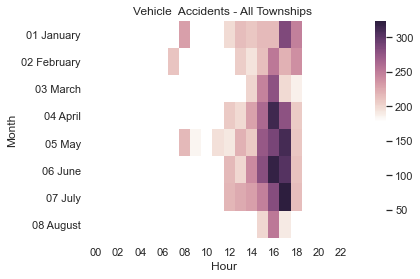

In [49]:
cmap = sns.cubehelix_palette(light=2, as_cmap=True)
ax = sns.heatmap(p,cmap = cmap)
ax.set_title('Vehicle  Accidents - All Townships ');

## EMS PIE CHART

In [50]:
df['type'] = df["title"].apply(lambda x: x.split(':')[0].strip())
tab=pd.crosstab(df['twp'],df['type']) 
ems = pd.DataFrame(tab[['EMS']])
ems.sort_values(by='EMS',axis=0, ascending=False, inplace=True)

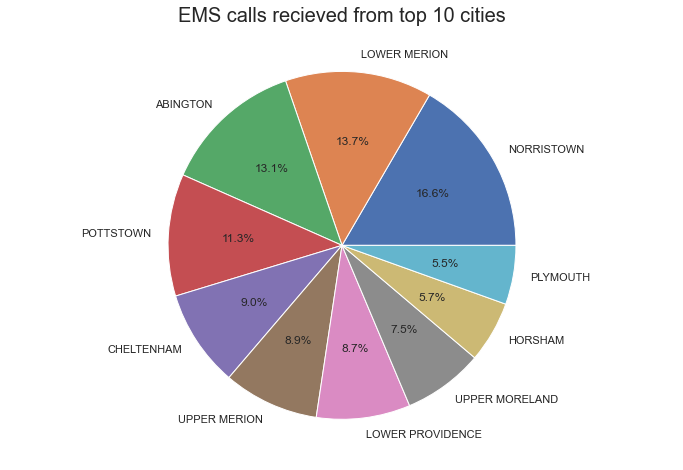

In [51]:
plt.figure(figsize=(12,8))
temp=ems[['EMS']].iloc[:10,:]
x_list = temp['EMS']
label_list = temp.index
plt.axis("equal") 
#To show the percentage of each pie slice, pass an output format to the autopctparameter 
plt.pie(x_list,labels=label_list,autopct="%1.1f%%") 
plt.title("EMS calls recieved from top 10 cities",fontdict=font) 
plt.savefig('ems-pie-Top10.png')
plt.show()

## FIRE PIE CHART

In [52]:
fire = pd.DataFrame(tab[['Fire']])
fire.sort_values(by='Fire',axis=0, ascending=False, inplace=True)

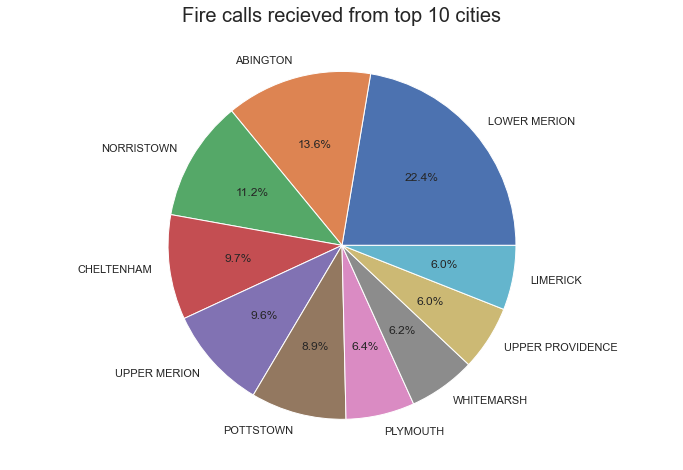

In [53]:
plt.figure(figsize=(12,8))
temp=fire[['Fire']].iloc[:10,:]
x_list = temp['Fire']
label_list = temp.index
plt.axis("equal") 
#To show the percentage of each pie slice, pass an output format to the autopctparameter 
plt.pie(x_list,labels=label_list,autopct="%1.1f%%") 
plt.title("Fire calls recieved from top 10 cities",fontdict=font) 
plt.savefig('fire-pie-Top10.png')
plt.show()

## Traffic PIE CHART

In [54]:
traffic = pd.DataFrame(tab[['Traffic']])
traffic.sort_values(by='Traffic',axis=0, ascending=False, inplace=True)

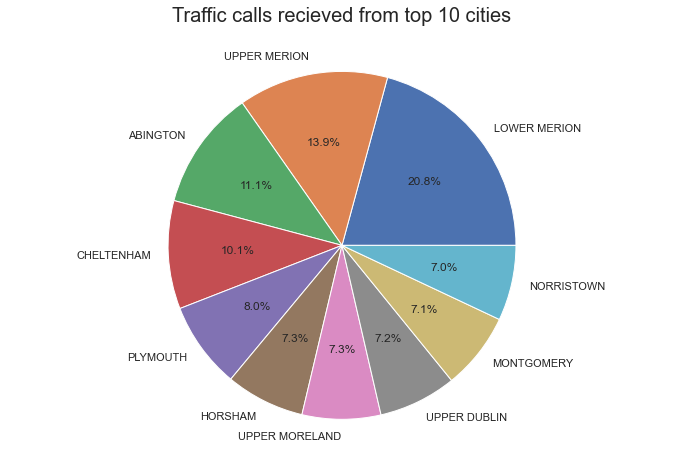

In [55]:
plt.figure(figsize=(12,8))
temp=traffic[['Traffic']].iloc[:10,:]
x_list = temp['Traffic']
label_list = temp.index
plt.axis("equal") 
#To show the percentage of each pie slice, pass an output format to the autopctparameter 
plt.pie(x_list,labels=label_list,autopct="%1.1f%%") 
plt.title("Traffic calls recieved from top 10 cities",fontdict=font) 
plt.savefig('Traffic-pie-Top10.png')
plt.show()

## EMS TYPE

In [56]:
ems = df[df['type']=='EMS']
ems['type'] = ems["title"].apply(lambda x: x.split(':')[1].strip())
ems.head()

C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,lat,lng,desc,zip,title,timeStamp,twp,addr,e,Reason,Hour,Month,Day of Week,Date,type
0,40.30,-75.58,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:40:00,NEW HANOVER,REINDEER CT & DEAD END,1,EMS,17,12,Thu,2015-12-10,BACK PAINS/INJURY
1,40.26,-75.26,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:40:00,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1,EMS,17,12,Thu,2015-12-10,DIABETIC EMERGENCY
3,40.12,-75.34,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 17:40:01,NORRISTOWN,AIRY ST & SWEDE ST,1,EMS,17,12,Thu,2015-12-10,CARDIAC EMERGENCY
4,40.25,-75.60,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 17:40:01,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1,EMS,17,12,Thu,2015-12-10,DIZZINESS
5,40.25,-75.28,CANNON AVE & W 9TH ST; LANSDALE; Station 345;...,19446.0,EMS: HEAD INJURY,2015-12-10 17:40:01,LANSDALE,CANNON AVE & W 9TH ST,1,EMS,17,12,Thu,2015-12-10,HEAD INJURY


In [57]:
ems_type = pd.DataFrame(ems['type'].value_counts(sort=True, ascending=False)).iloc[:10,:]
ems_type.head()

,type
RESPIRATORY EMERGENCY,5112
CARDIAC EMERGENCY,5012
FALL VICTIM,4863
VEHICLE ACCIDENT,3935
SUBJECT IN PAIN,2687


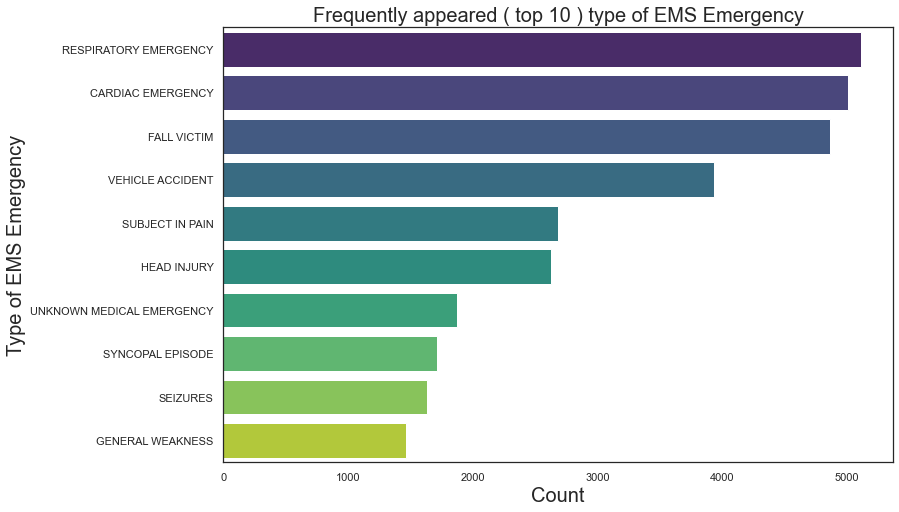

In [58]:
plt.figure(figsize=(12,8))
sns.barplot(x=ems_type['type'],y=ems_type.index,data=ems_type,palette="viridis") 
plt.xlabel("Count",fontdict=font)
plt.ylabel("Type of EMS Emergency",fontdict=font)
plt.title("Frequently appeared ( top 10 ) type of EMS Emergency",fontdict=font)
plt.savefig('Top10-EMS-Emergency.png')
plt.show()

## Fire Type

In [59]:
fire = df[df['type']=='Fire']
fire['type'] = fire["title"].apply(lambda x: x.split(':')[1].strip())

C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [60]:
fire_type = pd.DataFrame(fire['type'].value_counts(sort=True, ascending=False)).iloc[:10,:]

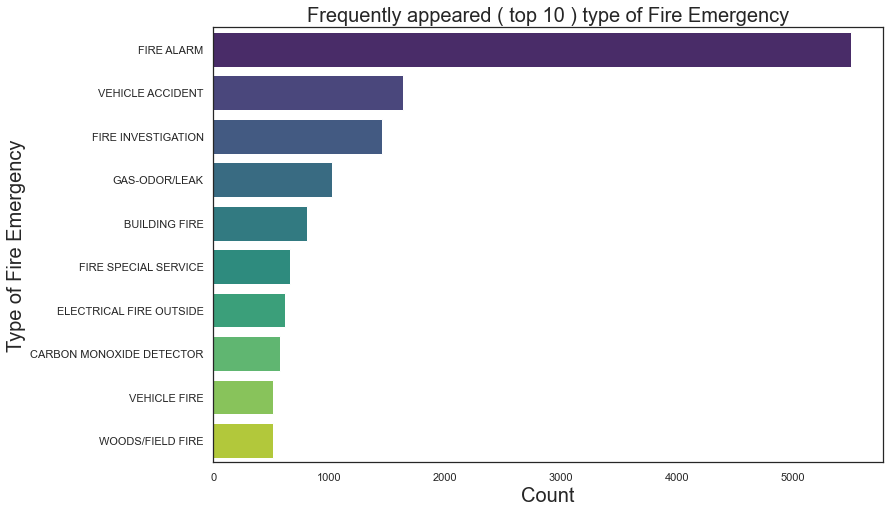

In [61]:
plt.figure(figsize=(12,8))
sns.barplot(x=fire_type['type'],y=fire_type.index,data=fire_type,palette="viridis") 
plt.xlabel("Count",fontdict=font)
plt.ylabel("Type of Fire Emergency",fontdict=font)
plt.title("Frequently appeared ( top 10 ) type of Fire Emergency",fontdict=font)
plt.savefig('Top10-Fire-Emergency.png')
plt.show()

## Traffic Type

In [62]:
traffic = df[df['type']=='Traffic']
traffic['type'] = traffic["title"].apply(lambda x: x.split(':')[1].strip())

C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [63]:
traffic_type = pd.DataFrame(traffic['type'].value_counts(sort=True, ascending=False)).iloc[:10,:]

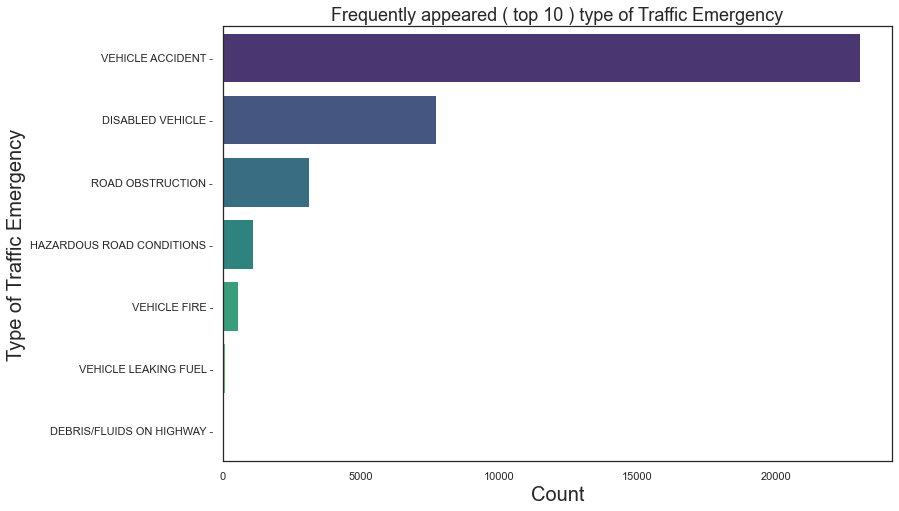

In [64]:
plt.figure(figsize=(12,8))
sns.barplot(x=traffic_type['type'],y=traffic_type.index,data=traffic_type,palette="viridis") 
plt.xlabel("Count",fontdict=font)
plt.ylabel("Type of Traffic Emergency",fontdict=font)
plt.title("Frequently appeared ( top 10 ) type of Traffic Emergency",fontsize=18)
plt.savefig('Top10-Traffic-Emergency.png')
plt.show()

## EDA based on Date and Time

In [65]:
tempdate = df.timeStamp

df['tempdate']=tempdate
df['year'] = df['tempdate'].dt.year
df['month'] = df['tempdate'].dt.month_name()
df['day']=df['tempdate'].dt.day_name()
df['hours'] =df['tempdate'].dt.hour

df.drop(['tempdate'],axis=1,inplace=True)

In [66]:
calls_month = df.groupby(['month', 'type'])['type'].count()
calls_month_percent = calls_month.groupby(level=0).apply(lambda x:round(100*x/float(x.sum())))

In [67]:
month_seq = [dt.date(2019, m, 1).strftime('%B') for m in range(1, 13)]

# reindexing level 0
calls_month_percent=calls_month_percent.reindex(month_seq, level=0)

# reindexing level 1
calls_month_percent = calls_month_percent.reindex(['EMS','Traffic','Fire'], level=1)

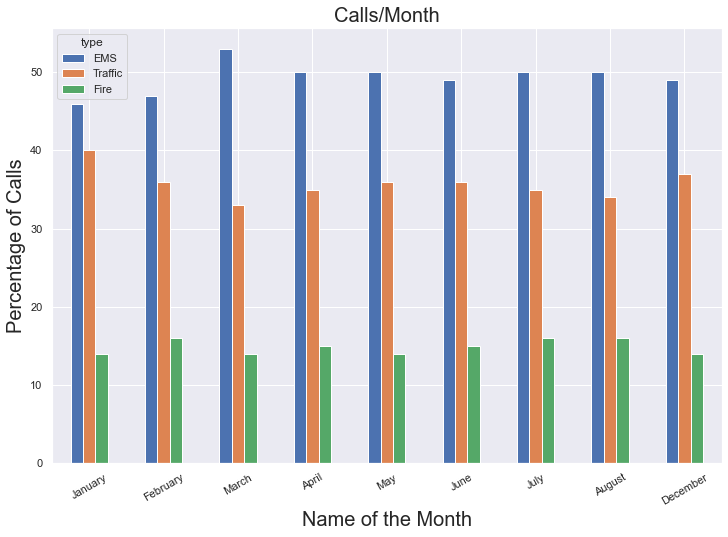

In [68]:
sns.set(rc={'figure.figsize':(12, 8)})
calls_month_percent.unstack().plot(kind='bar')
plt.xlabel('Name of the Month', fontdict=font)
plt.ylabel('Percentage of Calls', fontdict=font)
plt.xticks(rotation=30)
plt.title('Calls/Month', fontdict=font)
plt.savefig('call_vs_month.png')

In [69]:
calls_day = df.groupby(['day','type'])['type'].count()
calls_day_percent = calls_day.groupby(level=0).apply(lambda x:round(100*x/float(x.sum())))

In [70]:
import calendar
day_seq = list(calendar.day_name)
day_seq

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [71]:
calls_day_percent=calls_day_percent.reindex(day_seq, level=0)
calls_day_percent = calls_day_percent.reindex(['EMS','Traffic','Fire'], level=1)

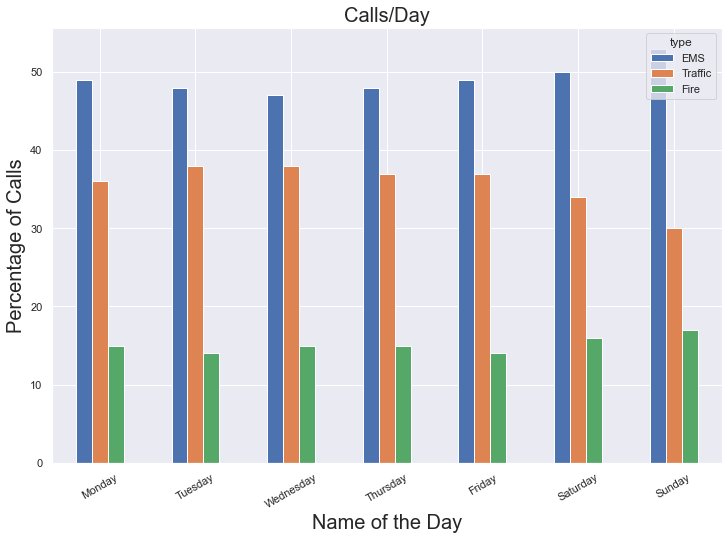

In [72]:
sns.set(rc={'figure.figsize':(12, 8)})
calls_day_percent.unstack().plot(kind='bar')
plt.xlabel('Name of the Day', fontdict=font)
plt.ylabel('Percentage of Calls', fontdict=font)
plt.xticks(rotation=30)
plt.title('Calls/Day', fontdict=font)
plt.savefig('call_vs_day.png')

In [73]:
calls_hour = df.groupby(['hours','type'])['type'].count()

In [74]:
calls_hour_percent = calls_hour.groupby(level=0).apply(lambda x:round(100*x/float(x.sum())))

In [75]:
calls_hour_percent = calls_hour_percent.reindex(['EMS','Traffic','Fire'], level=1)

Text(0.5, 1.0, 'Calls/Hour')

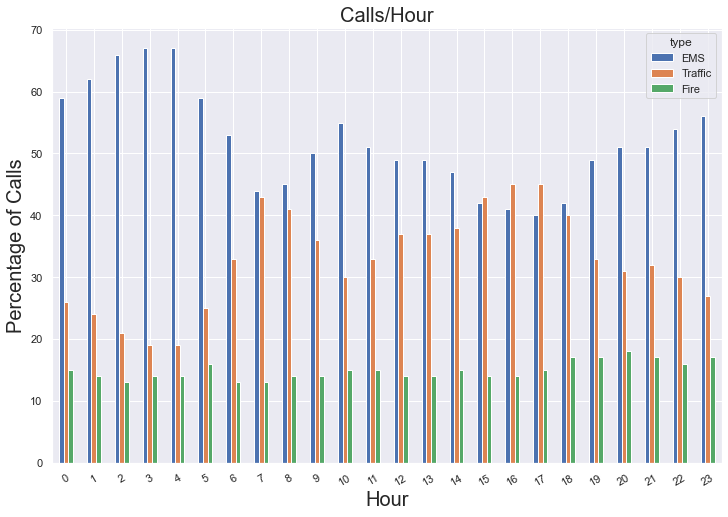

In [76]:
sns.set(rc={'figure.figsize':(12, 8)})
calls_hour_percent.unstack().plot(kind='bar')
plt.xlabel('Hour', fontdict=font)
plt.ylabel('Percentage of Calls', fontdict=font)
plt.xticks(rotation=30)
plt.title('Calls/Hour', fontdict=font)

# Dividing Data Based on It's Type EMS, Traffic, Fire.

In [77]:
# Extracting data for EMS
ems_city = df[df['type']=='EMS']
ems_city = ems_city.reset_index(drop = True) 

# Extracting data for Traffic
traffic_city =df[df['type']=='Traffic']
traffic_city = traffic_city.reset_index(drop = True) 

# Extracting Data for Fire
fire_city = df[df['type']=='Fire']
fire_city = fire_city.reset_index(drop = True) 


## Traffic Call Locations on Map

In [78]:
gdf_traffic = gpd.GeoDataFrame(traffic_city)


In [79]:
new_geo = gpd.GeoDataFrame()
new_geo['lat']=gdf_traffic['lat'].astype('float64')
new_geo['lng']=gdf_traffic['lng'].astype('float64')
new_geo['title']=gdf_traffic['title'].astype('object')
location = new_geo['lat'].mean(), new_geo['lng'].mean()

In [80]:
locationlist = new_geo[['lat','lng']].values.tolist()
labels = "CITY => "+ gdf_traffic['twp']+"\n"+gdf_traffic['title']

m = folium.Map(location=location, zoom_start=10)


for point in range(1,100): 
    popup = folium.Popup(labels[point], parse_html=True)
    icon = folium.Icon(color='orange')
    folium.Marker(locationlist[point], popup=popup, icon=icon).add_to(m)
    
m

In [81]:
gdf_fire = gpd.GeoDataFrame(fire_city)

In [82]:
new_geo = gpd.GeoDataFrame()
new_geo['lat']=gdf_fire['lat'].astype('float64')
new_geo['lng']=gdf_fire['lng'].astype('float64')
location = new_geo['lat'].mean(), new_geo['lng'].mean()

new_geo.shape

(14920, 2)

In [83]:
locationlist = new_geo[['lat','lng']].values.tolist()

labels = "CITY => "+ gdf_fire['twp']+"\n"+gdf_fire['title']

m = folium.Map(location=location, zoom_start=10)

for point in range(1,100): 
    popup = folium.Popup(labels[point], parse_html=True)
    icon = folium.Icon(color='purple')
    folium.Marker(locationlist[point], popup=popup, icon=icon).add_to(m)

m.save(outfile="Fire.html")
m

In [84]:
gdf_ems = gpd.GeoDataFrame(ems_city)

In [85]:
new_geo = gpd.GeoDataFrame()
new_geo['lat']=gdf_ems['lat'].astype('float64')
new_geo['lng']=gdf_ems['lng'].astype('float64')
location = new_geo['lat'].mean(), new_geo['lng'].mean()

In [86]:
locationlist = new_geo[['lat','lng']].values.tolist()

labels = "CITY => "+ gdf_ems['twp']+"\n"+gdf_ems['title']

m = folium.Map(location=location, zoom_start=10)

for point in range(1,100): 
    popup = folium.Popup(labels[point], parse_html=True)
    icon = folium.Icon(color='blue')
    folium.Marker(locationlist[point], popup=popup,icon=icon).add_to(m)
    
m.save(outfile= "EMS.html")
m

In [87]:
gdf = gpd.GeoDataFrame(df)

In [88]:
new_geo = gpd.GeoDataFrame()
new_geo['lat']=gdf['lat'].astype('float64')
new_geo['lng']=gdf['lng'].astype('float64')
new_geo['type']=gdf['type'].astype('object')
location = new_geo['lat'].mean(), new_geo['lng'].mean()

In [89]:
locationlist = new_geo[['lat','lng']].values.tolist()
labels = "CITY => "+ gdf['twp']+"\n"+gdf['title']
etype = gdf['type'].values.tolist()

m = folium.Map(location=location, zoom_start=10)

for point in range(1,600):
    if(etype[point] == 'EMS'):
        icon = folium.Icon(color='blue')
        label=labels[point]
    elif(etype[point]=='Traffic'):
        icon = folium.Icon(color='purple')
        label=labels[point]
    elif(etype[point]=='Fire'):
        icon = folium.Icon(color='red')
        label=labels[point]
    
    popup = folium.Popup(label, parse_html=True)
    folium.Marker(locationlist[point], popup=popup, icon=icon).add_to(m)
    
m.save(outfile= "All-Map-In-One.html")
m

In [90]:
#Plot the density of the emergencies on MAP
accdf = df
accdf=accdf.groupby(['lat','lng'])['lat'].count()
accdf=accdf.to_frame()
accdf.columns.values[0]='count1'
accdf=accdf.reset_index()
lats=accdf[['lat','lng','count1']].values.tolist()
    
hmap = folium.Map(location=[40.4, -75.2], zoom_start=9, )
hmap.add_child(HeatMap(lats, radius = 5))
hmap

## Probability Estimation and Methods Reports

In [91]:
df = df[['lat', 'lng', 'title']]

df.head(10)

,lat,lng,title
0,40.30,-75.58,EMS: BACK PAINS/INJURY
1,40.26,-75.26,EMS: DIABETIC EMERGENCY
2,40.12,-75.35,Fire: GAS-ODOR/LEAK
3,40.12,-75.34,EMS: CARDIAC EMERGENCY
4,40.25,-75.60,EMS: DIZZINESS
5,40.25,-75.28,EMS: HEAD INJURY
6,40.18,-75.13,EMS: NAUSEA/VOMITING
7,40.22,-75.41,EMS: RESPIRATORY EMERGENCY
8,40.29,-75.40,EMS: SYNCOPAL EPISODE
9,40.10,-75.29,Traffic: VEHICLE ACCIDENT -


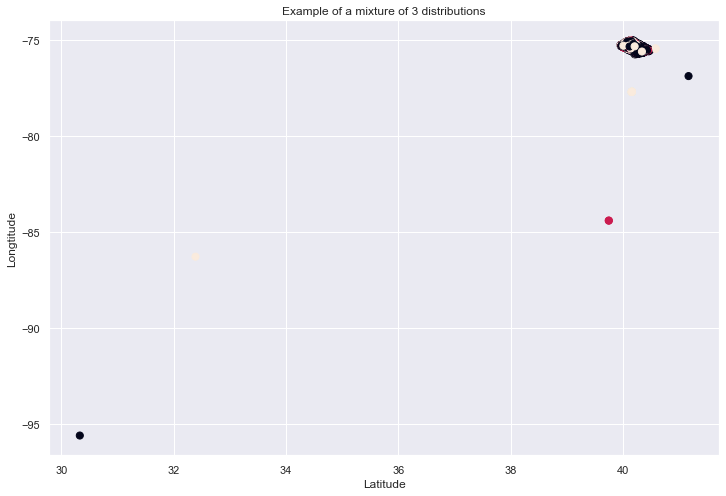

In [92]:
for i in range (0, df.shape[0]):
    df.iloc[i, 2] = df.iloc[i, 2][: df.iloc[i, 2].find(":")]

    
temp = np.unique(df['title'])
types = dict()
for type_id in range(0, len(temp)):
    types[temp[type_id]] = type_id

del temp

y = df.iloc[:, 2]
y = y.replace(types)

n_components = len(types)
X, truth = make_blobs(n_samples=df.shape[0], centers=n_components)
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], s=50, c = y)
plt.title(f"Example of a mixture of {n_components} distributions")
plt.xlabel("Latitude")
plt.ylabel("Longtitude");

From the graph above, **we cannot see any direct seperation of emergency type according to logtitude and latitude.** It makes finding the form of the density of this distribution not plausable. Instead of trying to find a form, we can try to find a probability depending on the calls around the input location.

With the approach we will be using **Nonparametric Methods**, we are assuming that calls from similar neighbourhood have similar emergency types. 

Types of Nonparametric Methods we can use are:
- Histogram Estimator
- Naive Estimator
- Kernel Estimator
- K Nearest Neighbor Estimator

### Case against Histogram Estimator:
In histogram estimator, we are dealing with fixed sized location boxes, we will refer these boxes as blocks. In the case of histogram estimator, we will select our neighbourhoods as prefixed sized blocks. Which means, model's prediction on new coordinates will only be effected by the points in that block. This approach may lead the model to not to use the closest points of the new call because they are not in the same block.

### Case against Naive and Kernel Estimators:
In these estimation methods, we are dealing with a fixed radius around the new point. In **Naive**, effects of the neighbouring points are weighted binary (1 or 0); if it is in the circle it is 1, if not it is 0. In **Kernel**, effects of the neighbouring points are weighted much smoothly than Naive Estimators. The problem is, if there is no or little amount of neighbours in this points radius, we have very little or nothing to work on and we lost a lot of processing time.

### Case against K Nearest Neighbor Estimator:
In K Nearest Neighbor Estimator, we are dealing with a prefixed amount of neighbouring points. Which means, model's prediction on new coordinates will only be effected by these points. If the new point is an outlier or the neighbours are scattered far away from each others, there can be kilometers of distance between the point and the neighbours. 

## Estimator Selection
Out of these estimators, Naive Estimator is a good method to use. Neighbours we are using in this method are more likely to be related to our point rather than KNN and Histogram Estimator. Also, less costly than Kernel Estimator.
**Down Below we implement Naive Estimator:**

In [93]:
def naive_estimator_evidence(neighbourhood, point, dataset):
    '''
        @arg neighbourhood: float
        @arg point: Array
        @arg dataset: pandas.DataFrame
        
        returns float
        
        neighbourhood:
            Radius around the given point, given as a float. Too small of a value may cause evidence value to be 0.
        point:
            Point of interest.
        dataset:
            Available dataset to calculate the probability of @point occuring.

    '''
    application_matrix = (point[0] - neighbourhood / 2) < dataset['lat']
    application_matrix *= (point[0] + neighbourhood / 2) >= dataset['lat']
    application_matrix *= (point[1] - neighbourhood / 2) < dataset['lng']
    application_matrix *= (point[1] + neighbourhood / 2) >= dataset['lng']
    
    return ((sum(application_matrix) / dataset.shape[0]))

In [94]:
def naive_estimator_likelihood(neighbourhood, point, dataset, emergency):
    '''
        @arg neighbourhood: float
        @arg point: array
        @arg dataset: pandas.DataFrame
        @arg emergency: String
        
        @returns float
                neighbourhood:
            Radius around the given point, given as a float. Too small of a value may cause evidence value to be 0.
        point:
            Point of interest.
        dataset:
            Available dataset to calculate the probability of @point occuring.
        emergency:
            Type of emergency occurence.
    '''
    emergency_set = dataset[dataset['title'] == emergency]
    likelihood = naive_estimator_evidence(neighbourhood, point, emergency_set)
    
    return (likelihood)

In [95]:
def prior(dataset, emergency):
    '''
        @arg dataset: pandas.DataFrame
        @arg emergency: String
        
        @returns float
        
        dataset:
            Available dataset to calculate the probability of @point occuring.
        emergency:
            Type of emergency occurence.
    '''
    emergency_set = dataset[dataset['title'] == emergency]
    prior = emergency_set.shape[0] / dataset.shape[0]
    
    return (prior)

In [96]:
def normalized_posterior(prior, likelihood, evidence):
    '''
        @arg prior: float
        @arg likelihood: float
        @arg evidence: float, evidence != 0
        
        @returns float
        
        prior:
            Prior probability value of the posterior to be calculated.
        likelihood:
            Likelihood value of the posterior to be calculated.
        evidence:
            Evidence value of the posterior to be calculated.
    '''
    
    posterior = prior * likelihood / evidence
    return(posterior)

In [97]:
def naive_estimator_posterior(neighbourhood, point, dataset, emergency):
    '''
        @arg neighbourhood: float
        @arg point: Array
        @arg dataset: pandas.DataFrame
        @arg emergency: String
        
        @return float
        
        neighbourhood:
            Radius around the given point, given as a float. Too small of a value may cause evidence value to be 0.
        point:
            Point of interest.
        dataset:
            Available dataset to calculate the probability of @point occuring.
        emergency:
            Type of emergency occurence.
    '''
    
    __evidence = naive_estimator_evidence(neighbourhood, point, df)
    __likelihood = naive_estimator_likelihood(neighbourhood, point, df, emergency)
    __prior = prior(df, emergency)
    __posterior = normalized_posterior(__prior, __likelihood, __evidence)
    
    return __posterior

## Improving Naive Estimator
If we leave or function like above, and given neighbourhood is too small, there can be situations which posterior is 0, just because we cannot reach to and other neighbor. We can add an expantion rate to our algorith so of probability is 0 we expand. If an event has never occured, expanding while probability is 0 can be dangerous, so we can limit our search with minimum and maximum boundaries of available data. Also we can show how wide of a search we are doing for better judment.

In [98]:
def naive_estimator_posterior_expandable(neighbourhood, point, dataset, emergency, expantion_rate=0.001):
    '''
        @arg neighbourhood: float
        @arg point: Array
        @arg dataset: pandas.DataFrame
        @arg emergency: String
        @arg expantion_rate: float, default=0.001
        
        returns Array[float, float]
        
        neighbourhood:
            Radius around the given point, given as a float. Too small of a value may cause evidence value to be 0.
        point:
            Point of interest.
        dataset:
            Available dataset to calculate the probability of @point occuring.
        emergency:
            Type of emergency occurence.
        expantion_rate:
            In case of not finding any available data points inside the given area, function expands its area
            by the expantion_rate.
    '''
    
    lat_boundaries = [dataset['lat'].min(), dataset['lat'].max()]
    lng_boundaries = [dataset['lng'].min(), dataset['lng'].max()]
    
    __evidence = naive_estimator_evidence(neighbourhood, point, df)
    
    while (__evidence == 0):
        if (lat_boundaries[0] > (point[0] - neighbourhood) and lat_boundaries[1] <= (point[0] + neighbourhood) and lng_boundaries[0] > (point[1] - neighbourhood) and lng_boundaries[1] <= (point[1] + neighbourhood)):
            return [neighbourhood, 0]
        
        neighbourhood += expantion_rate
        __evidence = naive_estimator_evidence(neighbourhood, point, df)
    
    __likelihood = naive_estimator_likelihood(neighbourhood, point, df, emergency)
    __prior = prior(df, emergency)
    __posterior = normalized_posterior(__prior, __likelihood, __evidence)
    
    while (__posterior == 0):
        if (lat_boundaries[0] > (point[0] - neighbourhood) and lat_boundaries[1] <= (point[0] + neighbourhood) and lng_boundaries[0] > (point[1] - neighbourhood) and lng_boundaries[1] <= (point[1] + neighbourhood)):
            return [neighbourhood, 0]
        
        neighbourhood += expantion_rate
        __evidence = naive_estimator_evidence(neighbourhood, point, df)
        __likelihood = naive_estimator_likelihood(neighbourhood, point, df, emergency)
        __posterior = normalized_posterior(__prior, __likelihood, __evidence)

    
    return [__posterior, neighbourhood]

## Kernel Estimator
If we want to take it one step further, we can use a non-binary weight function so further a neighbour get from the point, less effective it is. We can use Gaussian kernel for the weight function.

In [99]:
import math

def gaussian_kernel(x):
    result = (1/math.sqrt(2 * math.pi)) * math.exp(-(x**2)/2)
    return (result)

In [100]:
def euclidian_dist(x, y):
    '''
        @arg x: pandas.Series
        @arg y: pandas.Series
        
        @returns float
    '''
    result = math.sqrt((x[0] - y[0])**2 + (x[1] - y[1])**2)
    return (result)

In [101]:
def kernel_estimator_evidence(neighbourhood, point, dataset):
    '''
        @arg neighbourhood: float
        @arg point: pandas.Series
        @arg dataset: pandas.DataFrame
        
        @return float
        
        neighbourhood:
            Radius around the given point, given as a float. Too small of a value may cause evidence value to be 0.
        point:
            Point of interest.
        dataset:
            Available dataset to calculate the probability of @point occuring.
    '''
    application_matrix = (point[0] - neighbourhood / 2) < dataset['lat']
    application_matrix *= (point[0] + neighbourhood / 2) >= dataset['lat']
    application_matrix *= (point[1] - neighbourhood / 2) < dataset['lng']
    application_matrix *= (point[1] + neighbourhood / 2) >= dataset['lng']
    
    neighbors = dataset[application_matrix]
    evidence = 0
    
    for i in range (0, neighbors.shape[0]):
        item = neighbors.iloc[i, :2]
        distance = euclidian_dist(point, item)
        gaussian_weight = gaussian_kernel(distance)
        evidence += gaussian_weight
    return evidence / dataset.shape[0]

In [102]:
def kernel_estimator_likelihood(neighbourhood, point, dataset, emergency):
    '''
        @arg neighbourhood: float
        @arg point: pandas.Series
        @arg dataset: pandas.DataFrame
        @arg emergency: String
        
        @return float
        
        neighbourhood:
            Radius around the given point, given as a float. Too small of a value may cause evidence value to be 0.
        point:
            Point of interest.
        dataset:
            Available dataset to calculate the probability of @point occuring.
        emergency:
            Type of emergency occurence.
    '''
    emergency_set = dataset[dataset['title'] == emergency]
    likelihood = kernel_estimator_evidence(neighbourhood, point, emergency_set)
    
    return (likelihood)

In [103]:
def kernel_estimator_posterior_expandable(neighbourhood, point, dataset, emergency, expantion_rate=0.001):
    '''
        @arg neighbourhood: float
        @arg point: pandas.Series
        @arg dataset: pandas.DataFrame
        @arg emergency: String
        @arg expantion_rate: float
        
        @return float
        
        neighbourhood:
            Radius around the given point, given as a float. Too small of a value may cause evidence value to be 0.
        point:
            Point of interest.
        dataset:
            Available dataset to calculate the probability of @point occuring.
        emergency:
            Type of emergency occurence.
        expantion_rate:
            In case of not finding any available data points inside the given area, function expands its area
            by the expantion_rate.
    '''
        
    lat_boundaries = [dataset['lat'].min(), dataset['lat'].max()]
    lng_boundaries = [dataset['lng'].min(), dataset['lng'].max()]
    
    __evidence = kernel_estimator_evidence(neighbourhood, point, df)
    
    while (__evidence == 0):
        if (lat_boundaries[0] > (point[0] - neighbourhood) and lat_boundaries[1] <= (point[0] + neighbourhood) and lng_boundaries[0] > (point[1] - neighbourhood) and lng_boundaries[1] <= (point[1] + neighbourhood)):
            return [neighbourhood, 0]
        
        neighbourhood += expantion_rate
        __evidence = kernel_estimator_evidence(neighbourhood, point, df)
    
    __likelihood = kernel_estimator_likelihood(neighbourhood, point, df, emergency)
    __prior = prior(df, emergency)
    __posterior = normalized_posterior(__prior, __likelihood, __evidence)
    
    while (__posterior == 0):
        if (lat_boundaries[0] > (point[0] - neighbourhood) and lat_boundaries[1] <= (point[0] + neighbourhood) and lng_boundaries[0] > (point[1] - neighbourhood) and lng_boundaries[1] <= (point[1] + neighbourhood)):
            return [neighbourhood, 0]
        
        neighbourhood += expantion_rate
        __evidence = kernel_estimator_evidence(neighbourhood, point, df)
        __likelihood = kernel_estimator_likelihood(neighbourhood, point, df, emergency)
        __posterior = normalized_posterior(__prior, __likelihood, __evidence)

    
    return [__posterior, neighbourhood]

In [104]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :2]
y = df.iloc[:, 2]
train, test = train_test_split(df, test_size=0.2, random_state=21)

X_test = test.iloc[:, :2]
y_test = test.iloc[:, 2]

In [105]:
# Calculate accuracy for Naive Estimator

result = []
temp = np.unique(df['title'])

for i in range(0, X_test.shape[0]):
    best_posterior = 0
    best_class = ''
    for title in temp:
        posterior = naive_estimator_posterior(0.001, X_test.iloc[i, :], train, title)
        
        if(posterior > best_posterior):
            best_posterior = posterior
            best_class = title
    result.append(best_class)
    
print("Accuracy for naive_estimator_posterior with 0.001 neighbour: ", sum(result == y_test) / len(result) * 100)

C:\Users\Diogo\AppData\Roaming\Python\Python37\site-packages\pandas\core\computation\expressions.py:183: UserWarning:

evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead



Accuracy for naive_estimator_posterior with 0.001 neighbour:  58.55068093874064


In [106]:
# Calculate accuracy for Extended Naive Estimator

result = []
temp = np.unique(df['title'])

for i in range(0, X_test.shape[0]):
    best_posterior = 0
    best_class = ''
    for title in temp:
        posterior = naive_estimator_posterior_expandable(0.001, X_test.iloc[i, :], train, title, expantion_rate=0.001)
        
        if(posterior[0] > best_posterior):
            best_posterior = posterior[0]
            best_class = title
    result.append(best_class)
    
print("Accuracy for naive_estimator_posterior with 0.001 neighbour: ", sum(result == y_test) / len(result) * 100)

Accuracy for naive_estimator_posterior with 0.001 neighbour:  58.530579426101816


In [107]:
# Calculate accuracy for Gaussian Kernel Estimator

result = []
temp = np.unique(df['title'])

for i in range(0, X_test.shape[0]):
    best_posterior = 0
    best_class = ''
    for title in temp:
        posterior = kernel_estimator_posterior_expandable(0.001, X_test.iloc[i, :], train, title, expantion_rate=0.001)
        
        if(posterior[0] > best_posterior):
            best_posterior = posterior[0]
            best_class = title

    result.append(best_class)
    
print("Accuracy for naive_estimator_posterior with 0.001 neighbour: ", sum(result == y_test) / len(result) * 100)

KeyboardInterrupt: 